In [1]:
# %% Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from yahooquery import Ticker
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from data_fetcher import fetch_ticker_data
import pickle
import warnings
warnings.filterwarnings("ignore")

# %% Helper functions for technical indicators
def compute_rsi(series, window=14):
    """Compute the Relative Strength Index (RSI) for a given series."""
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def compute_macd(series, short_window=12, long_window=26, signal_window=9):
    """Compute the MACD and signal line."""
    short_ema = series.ewm(span=short_window, min_periods=1).mean()
    long_ema = series.ewm(span=long_window, min_periods=1).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, min_periods=1).mean()
    return macd, signal

def compute_trending_down_percentage(df_ticker_data, period=5):
    """Compute the percentage of stocks in the dataset trending down over the specified period."""
    trending_down = sum(
        df_ticker_data.groupby('symbol').apply(
            lambda stock: stock['adjclose'].iloc[-1] / stock['adjclose'].iloc[-(period + 1)] - 1 < 0
        )
    )
    total_stocks = len(df_ticker_data['symbol'].unique())
    return (trending_down / total_stocks) * 100

def compute_market_breadth_indicators(df_ticker_data, tickers_mini):
    """Compute additional market breadth and sentiment indicators."""
    df_filtered = df_ticker_data[df_ticker_data['symbol'].isin(tickers_mini)]
    
    def is_above_200d_ma(stock_data):
        try:
            return stock_data['adjclose'].iloc[-1] > stock_data['adjclose'].rolling(window=200).mean().iloc[-1]
        except:
            return False
    
    above_200d_ma = df_filtered.groupby('symbol').apply(is_above_200d_ma).sum()
    pct_above_200d_ma = (above_200d_ma / len(tickers_mini)) * 100
    
    def compute_return_std(group):
        try:
            return group['adjclose'].pct_change().std()
        except:
            return 0
    
    market_return_std = df_filtered.groupby('symbol').apply(compute_return_std).mean()
    
    def is_52_week_high(stock_data):
        try:
            return stock_data['adjclose'].iloc[-1] == stock_data['adjclose'].rolling(window=252).max().iloc[-1]
        except:
            return False
    
    def is_52_week_low(stock_data):
        try:
            return stock_data['adjclose'].iloc[-1] == stock_data['adjclose'].rolling(window=252).min().iloc[-1]
        except:
            return False
    
    new_highs = df_filtered.groupby('symbol').apply(is_52_week_high).sum()
    new_lows = df_filtered.groupby('symbol').apply(is_52_week_low).sum()
    new_highs_ratio = (new_highs / len(tickers_mini)) * 100
    new_lows_ratio = (new_lows / len(tickers_mini)) * 100
    
    def compute_correlation(group):
        try:
            returns = group['adjclose'].pct_change()
            return returns
        except:
            return pd.Series()
    
    try:
        daily_returns = df_filtered.groupby('symbol').apply(compute_correlation)
        correlations = daily_returns.corr().mean().mean()
    except:
        correlations = 0
    
    def compute_momentum(stock_data, momentum_window=20):
        try:
            return stock_data['adjclose'].iloc[-1] / stock_data['adjclose'].iloc[-momentum_window] - 1
        except:
            return 0
    
    sector_momentum = df_filtered.groupby('symbol').apply(
        lambda stock: compute_momentum(stock)
    ).mean() * 100
    
    return {
        'pct_above_200d_ma': pct_above_200d_ma,
        'market_return_std': market_return_std,
        'new_highs_ratio': new_highs_ratio,
        'new_lows_ratio': new_lows_ratio,
        'avg_stock_correlation': correlations,
        'sector_momentum': sector_momentum
    }

# %% Data fetching and preprocessing
def load_tickers(file_path):
    """Load tickers from an Excel file."""
    tickers = pd.read_excel(file_path)
    return tickers[tickers.Country == "United States"].Ticker.unique().tolist()

def fetch_data(tickers, period='max', interval='1d'):
    """Fetch data for the tickers."""
    return fetch_ticker_data(tickers, period=period, interval=interval, filename=None)

def prepare_features_and_targets(df_ticker_data, tickers_mini, period=5):
    """Prepare features and targets for modeling."""
    # Filter data for XBI and SPY
    df_xbi = df_ticker_data[df_ticker_data['symbol'] == 'XBI'].copy()
    df_spy = df_ticker_data[df_ticker_data['symbol'] == 'SPY'].copy()
    
    # Calculate indicators for XBI
    df_xbi['7d_ma_XBI'] = df_xbi['adjclose'].rolling(window=7).mean()
    df_xbi['14d_rsi_XBI'] = compute_rsi(df_xbi['adjclose'])
    df_xbi['30d_ma_XBI'] = df_xbi['adjclose'].rolling(window=30).mean()
    df_xbi['macd_XBI'], df_xbi['macd_signal_XBI'] = compute_macd(df_xbi['adjclose'])
    df_xbi['volatility_XBI'] = df_xbi['adjclose'].rolling(window=14).std()
    df_xbi['percentage_trending_down'] = compute_trending_down_percentage(
        df_ticker_data[df_ticker_data['symbol'].isin(tickers_mini)], period
    )
    
    # Compute market breadth indicators
    market_breadth = compute_market_breadth_indicators(df_ticker_data, tickers_mini)
    
    # Add market breadth indicators to the XBI dataframe
    df_xbi['pct_above_200d_ma'] = market_breadth['pct_above_200d_ma']
    df_xbi['market_return_std'] = market_breadth['market_return_std']
    df_xbi['new_highs_ratio'] = market_breadth['new_highs_ratio']
    df_xbi['new_lows_ratio'] = market_breadth['new_lows_ratio']
    df_xbi['avg_stock_correlation'] = market_breadth['avg_stock_correlation']
    df_xbi['sector_momentum'] = market_breadth['sector_momentum']
    
    # Define target for XBI: Local maxima = Top, Local minima = Bottom
    df_xbi['target_XBI'] = 0
    df_xbi.loc[df_xbi['adjclose'] == df_xbi['adjclose'].rolling(window=30).max(), 'target_XBI'] = 1
    df_xbi.loc[df_xbi['adjclose'] == df_xbi['adjclose'].rolling(window=30).min(), 'target_XBI'] = -1
    # OUTPUT THIS

    # Calculate indicators for SPY
    df_spy['7d_ma_SPY'] = df_spy['adjclose'].rolling(window=7).mean()
    df_spy['14d_rsi_SPY'] = compute_rsi(df_spy['adjclose'])
    df_spy['30d_ma_SPY'] = df_spy['adjclose'].rolling(window=30).mean()
    df_spy['macd_SPY'], df_spy['macd_signal_SPY'] = compute_macd(df_spy['adjclose'])
    df_spy['volatility_SPY'] = df_spy['adjclose'].rolling(window=14).std()
    
    # Merge SPY features into XBI
    df_combined = pd.merge(
        df_xbi, 
        df_spy[['date', 'adjclose', '7d_ma_SPY', '14d_rsi_SPY', '30d_ma_SPY', 'macd_SPY', 'macd_signal_SPY', 'volatility_SPY']], 
        on='date', 
        suffixes=('_XBI', '_SPY')
    )
    
    # Filter columns for features and target
    feature_columns = ['7d_ma_XBI', '14d_rsi_XBI', '30d_ma_XBI', 'macd_XBI', 'macd_signal_XBI', 
                       'volatility_XBI', 'pct_above_200d_ma', 'market_return_std', 'new_highs_ratio', 
                       'new_lows_ratio', 'avg_stock_correlation', 'sector_momentum', 
                       '7d_ma_SPY', '14d_rsi_SPY', '30d_ma_SPY', 'macd_SPY', 'macd_signal_SPY', 'volatility_SPY']

    #feature_columns = ['new_highs_ratio', 'new_lows_ratio',  '30d_ma_SPY']
    X_combined = df_combined[feature_columns].fillna(0)  # Handle any missing values in features
    y_combined = df_combined['target_XBI']  # The target variable
    
    return X_combined, y_combined

# %% Model training and evaluation
def initialize_models():
    """Initialize and return a dictionary of models."""
    return {
        'DecisionTree': DecisionTreeClassifier(
            max_depth=3,  # Limit the depth of the tree
            min_samples_split=10,  # Minimum samples required to split an internal node
            min_samples_leaf=5,  # Minimum samples required to be at a leaf node
            random_state=42
        )  
    }

def train_and_evaluate_model(X_combined, y_combined):
    """Train and evaluate the decision tree model."""
    X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42,shuffle=False)
     
    models = initialize_models()
    model = models['DecisionTree']
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    
    # Plot the decision tree
    plt.figure(figsize=(20,10))
    plot_tree(model, 
              feature_names=X_combined.columns, 
              class_names=['Bottom', 'Neutral', 'Top'], 
              filled=True, 
              rounded=True, 
              impurity=True)
    plt.show()

# %% Main script execution
if __name__ == "__main__":
    # Load tickers and fetch data
    tickers = load_tickers("Input/Complete-List-of-Biotech-Stocks-Listed-on-NASDAQ-Jan-1-24.xlsx")
    tickers_mini = tickers  # Sample for testing
    benchmark_tickers = ["XBI", "SPY"]
    tickers_full = tickers_mini + benchmark_tickers
    
    # Fetch data
    df_ticker_daily = fetch_data(tickers_full)

    
    # Prepare features and targets for model
    X_combined, y_combined = prepare_features_and_targets(df_ticker_daily, tickers_full, period=5)
    
    # Train and evaluate the model
    train_and_evaluate_model(X_combined, y_combined)


IndexError: single positional indexer is out-of-bounds

# Plot to identify top / bottom from moving average classification alone

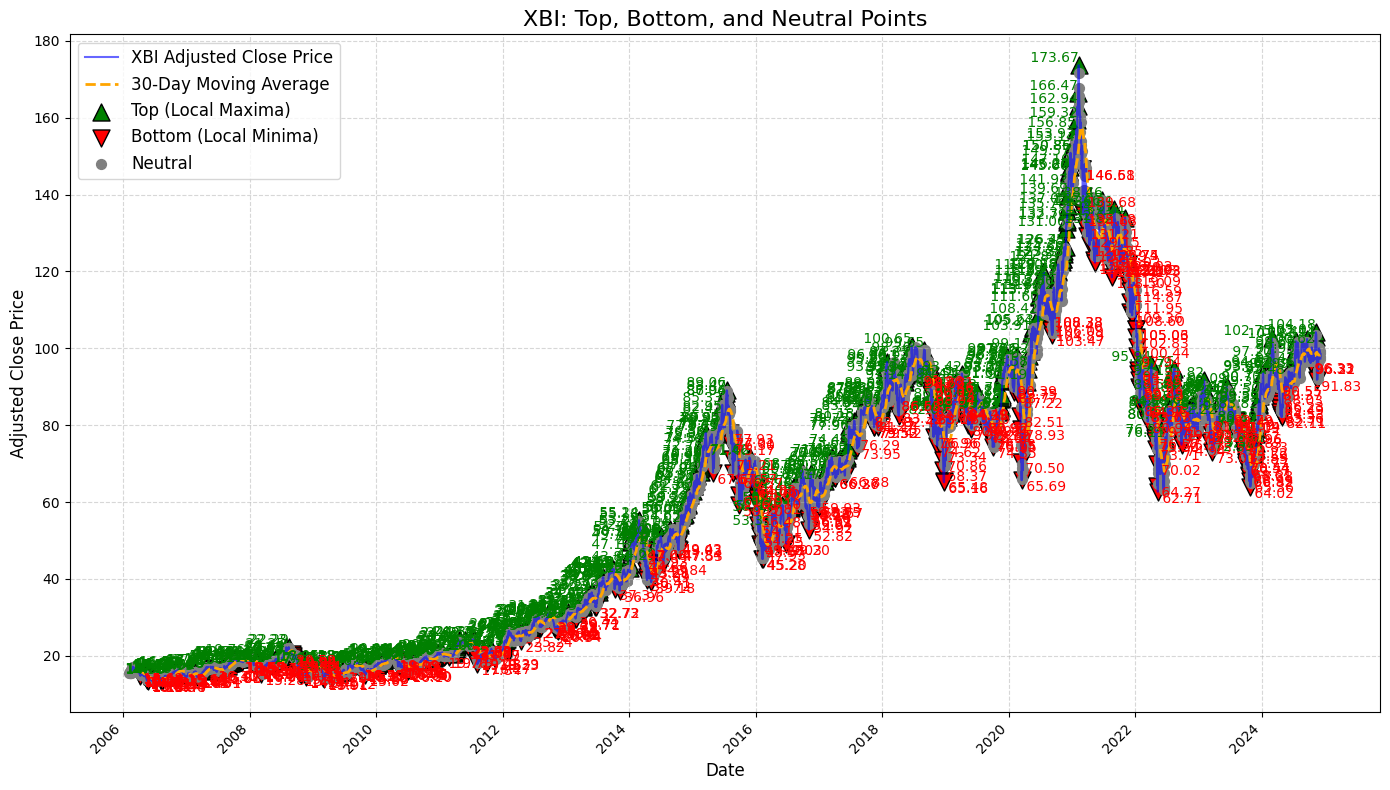

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from yahooquery import Ticker

# %% Fetch data for XBI (adjust with your data source)
def fetch_xbi_data():
    """Fetch XBI data from Yahoo Finance"""
    ticker = Ticker("XBI")
    df = ticker.history(period="max", interval="1d")
    df = df.reset_index()
    return df

# %% Define target for XBI: Local maxima = Top, Local minima = Bottom
def classify_top_bottom_neutral(df):
    """Classify points as Top, Bottom, or Neutral"""
    df['target_XBI'] = 0  # Default to neutral
    df.loc[df['adjclose'] == df['adjclose'].rolling(window=30).max(), 'target_XBI'] = 1  # Top (Local Maxima)
    df.loc[df['adjclose'] == df['adjclose'].rolling(window=30).min(), 'target_XBI'] = -1  # Bottom (Local Minima)
    return df

# %% Plot XBI with Top, Bottom, and Neutral points
def plot_xbi_classification(df):
    """Plot XBI data with Top, Bottom, and Neutral points"""
    plt.figure(figsize=(14, 8))
    
    # Plot XBI adjusted close price with a smoothed line (e.g., 30-day rolling average)
    plt.plot(df['date'], df['adjclose'], label='XBI Adjusted Close Price', color='blue', alpha=0.6)
    plt.plot(df['date'], df['adjclose'].rolling(window=30).mean(), label='30-Day Moving Average', color='orange', linestyle='--', linewidth=2)
    
    # Plot local maxima (Top) with larger markers and annotations
    top_points = df[df['target_XBI'] == 1]
    plt.scatter(top_points['date'], top_points['adjclose'], color='green', label='Top (Local Maxima)', marker='^', s=150, edgecolors='black')
    for i, row in top_points.iterrows():
        plt.text(row['date'], row['adjclose'], f" {row['adjclose']:.2f}", color='green', fontsize=10, ha='right', va='bottom')
    
    # Plot local minima (Bottom) with larger markers and annotations
    bottom_points = df[df['target_XBI'] == -1]
    plt.scatter(bottom_points['date'], bottom_points['adjclose'], color='red', label='Bottom (Local Minima)', marker='v', s=150, edgecolors='black')
    for i, row in bottom_points.iterrows():
        plt.text(row['date'], row['adjclose'], f" {row['adjclose']:.2f}", color='red', fontsize=10, ha='left', va='top')
    
    # Highlight the neutral points with smaller markers
    neutral_points = df[df['target_XBI'] == 0]
    plt.scatter(neutral_points['date'], neutral_points['adjclose'], color='gray', label='Neutral', marker='o', s=50)
    
    # Formatting plot
    plt.title('XBI: Top, Bottom, and Neutral Points', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Adjusted Close Price', fontsize=12)
    plt.legend(loc='best', fontsize=12)
    
    # Rotate the x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    
    # Gridlines (optional, can be removed for a cleaner look)
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Tight layout to prevent overlapping
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# %% Main execution
if __name__ == "__main__":
    # Fetch data for XBI
    df_xbi = fetch_xbi_data()
    
    # Ensure 'date' column is in datetime format
    df_xbi['date'] = pd.to_datetime(df_xbi['date'])
    
    # Classify Top, Bottom, and Neutral points
    df_xbi = classify_top_bottom_neutral(df_xbi)
    
    # Plot the data with classifications
    plot_xbi_classification(df_xbi)


# Plot to identify top / bottom from 80/20 split

Classification Report:
               precision    recall  f1-score   support

          -1       0.49      0.47      0.48        96
           0       0.86      0.93      0.90       777
           1       0.76      0.17      0.28        76

    accuracy                           0.83       949
   macro avg       0.71      0.52      0.55       949
weighted avg       0.82      0.83      0.81       949

Confusion Matrix:
 [[ 45  51   0]
 [ 47 726   4]
 [  0  63  13]]
Test Accuracy: 0.8261327713382508


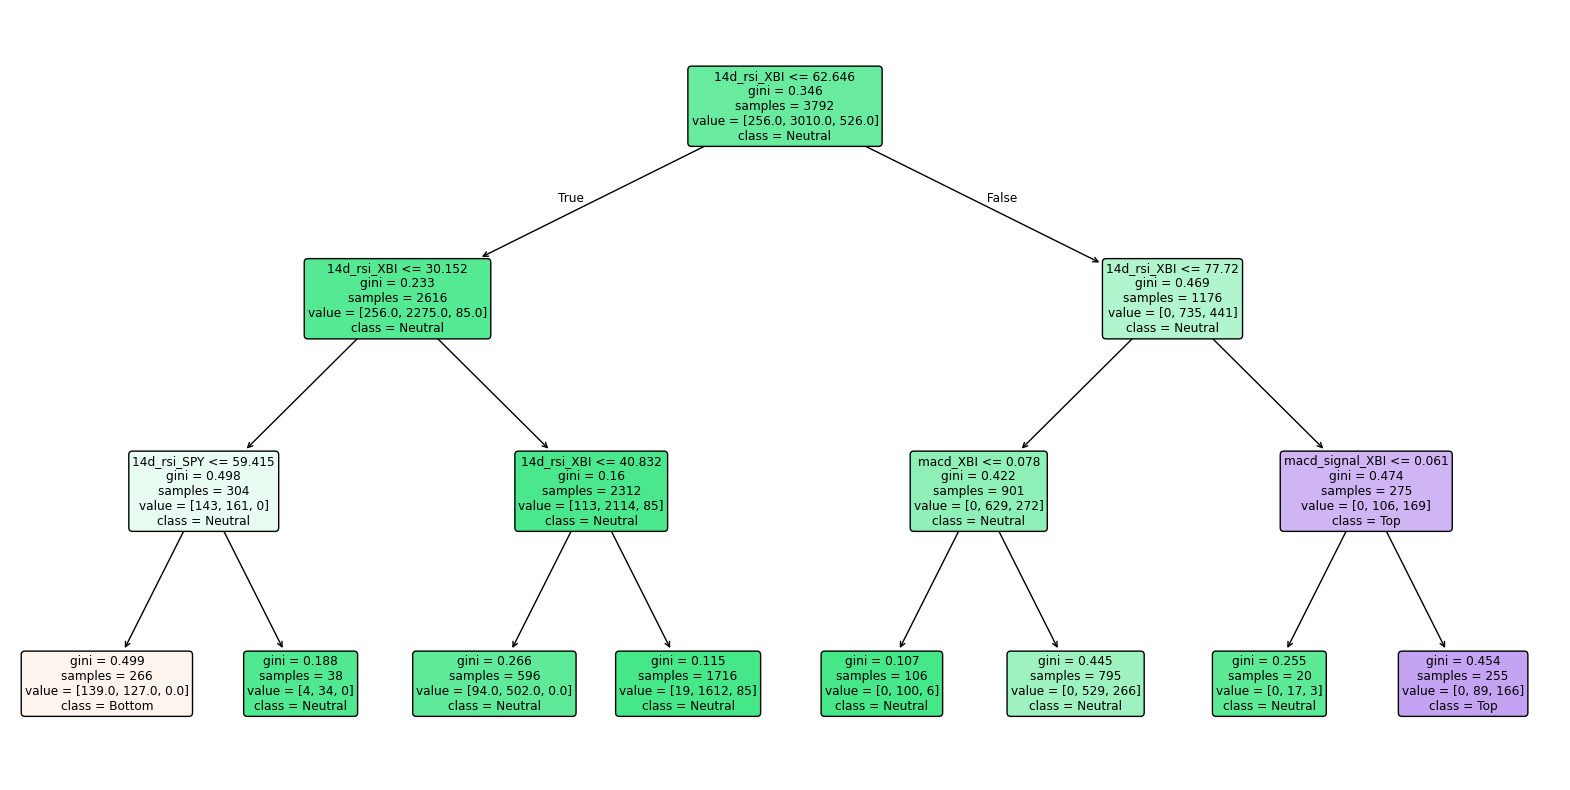

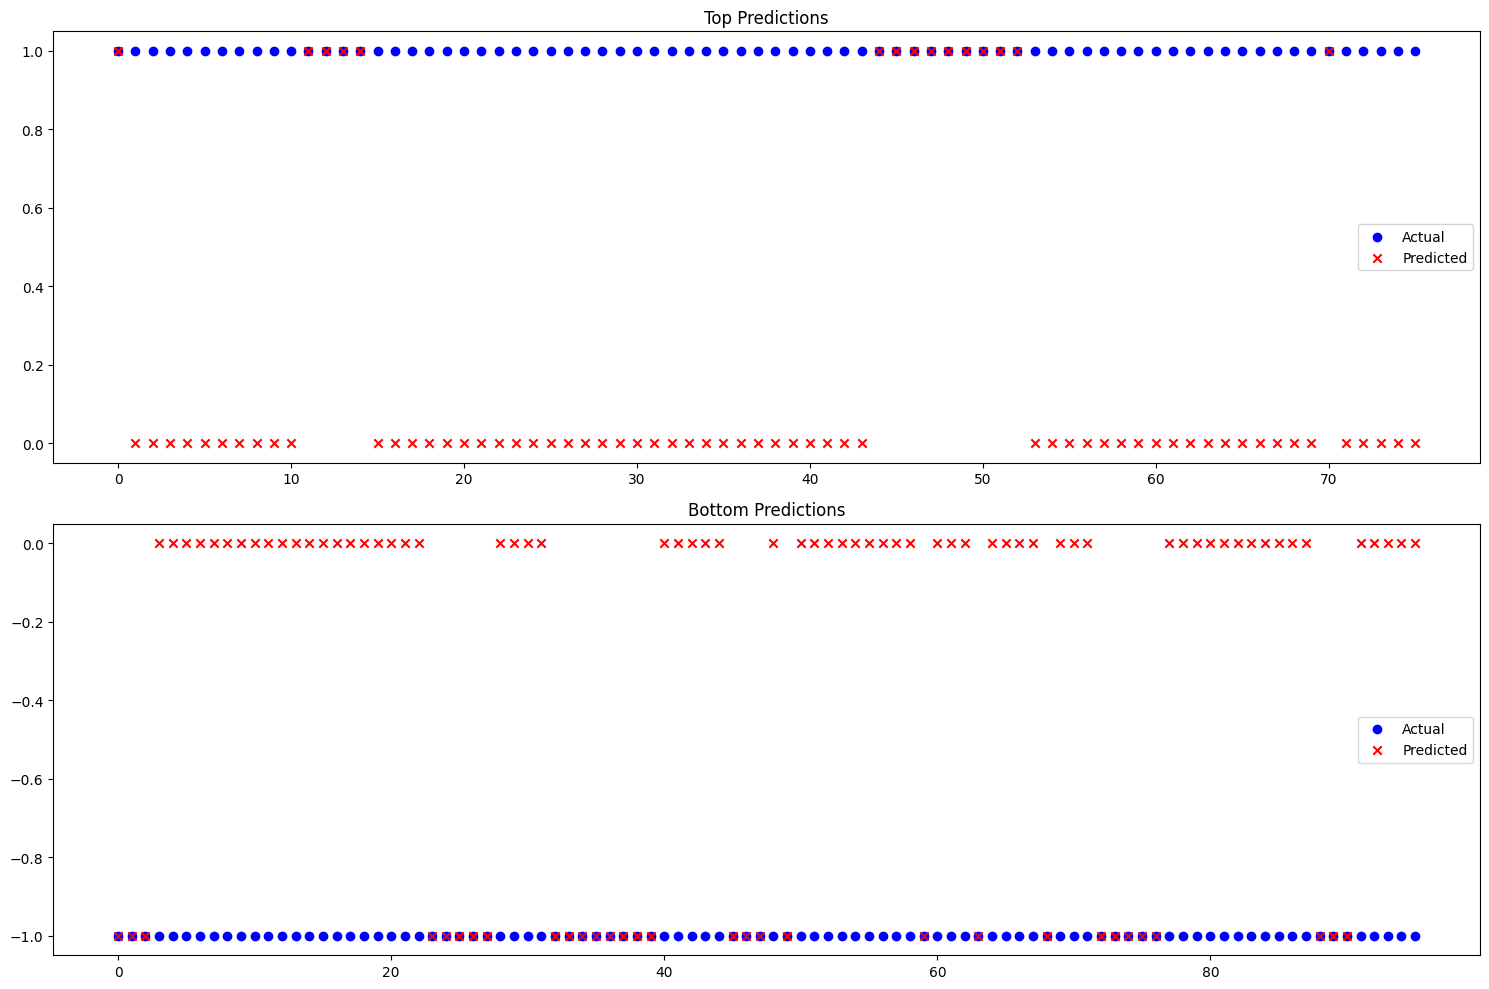

AssertionError: 

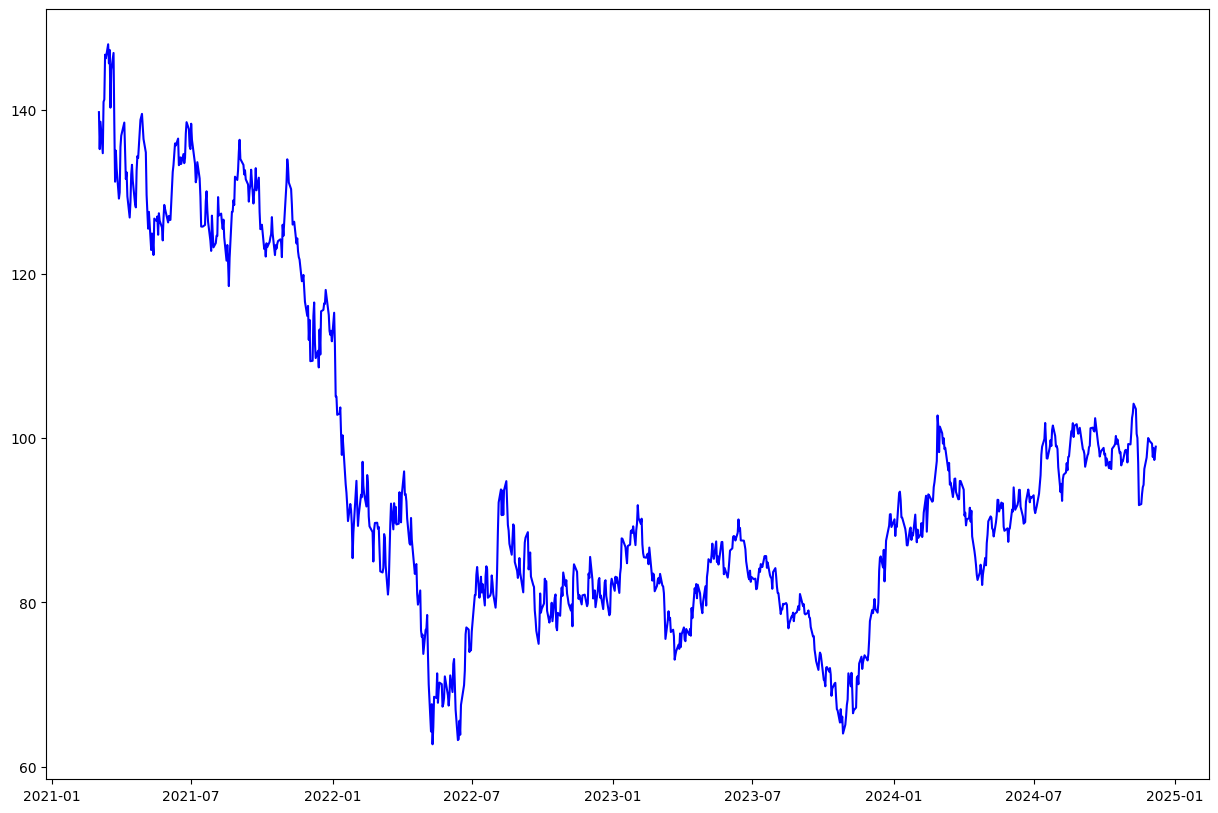

In [ ]:
# %% Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from yahooquery import Ticker
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from data_fetcher import fetch_ticker_data
import pickle,os
import warnings
warnings.filterwarnings("ignore")

# %% Helper functions for technical indicators
def compute_rsi(series, window=14):
    """Compute the Relative Strength Index (RSI) for a given series."""
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def compute_macd(series, short_window=12, long_window=26, signal_window=9):
    """Compute the MACD and signal line."""
    short_ema = series.ewm(span=short_window, min_periods=1).mean()
    long_ema = series.ewm(span=long_window, min_periods=1).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, min_periods=1).mean()
    return macd, signal

def compute_trending_down_percentage(df_ticker_data, period=5):
    """Compute the percentage of stocks in the dataset trending down over the specified period."""
    trending_down = sum(
        df_ticker_data.groupby('symbol').apply(
            lambda stock: stock['adjclose'].iloc[-1] / stock['adjclose'].iloc[-(period + 1)] - 1 < 0
        )
    )
    total_stocks = len(df_ticker_data['symbol'].unique())
    return (trending_down / total_stocks) * 100

def compute_market_breadth_indicators(df_ticker_data, tickers_mini):
    """Compute additional market breadth and sentiment indicators."""
    df_filtered = df_ticker_data[df_ticker_data['symbol'].isin(tickers_mini)]
    
    def is_above_200d_ma(stock_data):
        try:
            return stock_data['adjclose'].iloc[-1] > stock_data['adjclose'].rolling(window=200).mean().iloc[-1]
        except:
            return False
    
    above_200d_ma = df_filtered.groupby('symbol').apply(is_above_200d_ma).sum()
    pct_above_200d_ma = (above_200d_ma / len(tickers_mini)) * 100
    
    def compute_return_std(group):
        try:
            return group['adjclose'].pct_change().std()
        except:
            return 0
    
    market_return_std = df_filtered.groupby('symbol').apply(compute_return_std).mean()
    
    def is_52_week_high(stock_data):
        try:
            return stock_data['adjclose'].iloc[-1] == stock_data['adjclose'].rolling(window=252).max().iloc[-1]
        except:
            return False
    
    def is_52_week_low(stock_data):
        try:
            return stock_data['adjclose'].iloc[-1] == stock_data['adjclose'].rolling(window=252).min().iloc[-1]
        except:
            return False
    
    new_highs = df_filtered.groupby('symbol').apply(is_52_week_high).sum()
    new_lows = df_filtered.groupby('symbol').apply(is_52_week_low).sum()
    new_highs_ratio = (new_highs / len(tickers_mini)) * 100
    new_lows_ratio = (new_lows / len(tickers_mini)) * 100
    
    def compute_correlation(group):
        try:
            returns = group['adjclose'].pct_change()
            return returns
        except:
            return pd.Series()
    
    try:
        daily_returns = df_filtered.groupby('symbol').apply(compute_correlation)
        correlations = daily_returns.corr().mean().mean()
    except:
        correlations = 0
    
    def compute_momentum(stock_data, momentum_window=20):
        try:
            return stock_data['adjclose'].iloc[-1] / stock_data['adjclose'].iloc[-momentum_window] - 1
        except:
            return 0
    
    sector_momentum = df_filtered.groupby('symbol').apply(
        lambda stock: compute_momentum(stock)
    ).mean() * 100
    
    return {
        'pct_above_200d_ma': pct_above_200d_ma,
        'market_return_std': market_return_std,
        'new_highs_ratio': new_highs_ratio,
        'new_lows_ratio': new_lows_ratio,
        'avg_stock_correlation': correlations,
        'sector_momentum': sector_momentum
    }

# %% Data fetching and preprocessing
def load_tickers(file_path):
    """Load tickers from an Excel file."""
    tickers = pd.read_excel(file_path)
    return tickers[tickers.Country == "United States"].Ticker.unique().tolist()

def fetch_data(tickers, period='max', interval='1d'):
    """Fetch data for the tickers."""
    return fetch_ticker_data(tickers, period=period, interval=interval, filename=None)

def prepare_features_and_targets(df_ticker_data, tickers_mini, period=5):
    """Prepare features and targets for modeling."""
    # Filter data for XBI and SPY
    df_xbi = df_ticker_data[df_ticker_data['symbol'] == 'XBI'].copy()
    df_spy = df_ticker_data[df_ticker_data['symbol'] == 'SPY'].copy()
    
    # Calculate indicators for XBI
    df_xbi['7d_ma_XBI'] = df_xbi['adjclose'].rolling(window=7).mean()
    df_xbi['14d_rsi_XBI'] = compute_rsi(df_xbi['adjclose'])
    df_xbi['30d_ma_XBI'] = df_xbi['adjclose'].rolling(window=30).mean()
    df_xbi['macd_XBI'], df_xbi['macd_signal_XBI'] = compute_macd(df_xbi['adjclose'])
    df_xbi['volatility_XBI'] = df_xbi['adjclose'].rolling(window=14).std()
    
    # Compute market breadth indicators
    market_breadth = compute_market_breadth_indicators(df_ticker_data, tickers_mini)
    
    # Add market breadth indicators to the XBI dataframe
    df_xbi['pct_above_200d_ma'] = market_breadth['pct_above_200d_ma']
    df_xbi['market_return_std'] = market_breadth['market_return_std']
    df_xbi['new_highs_ratio'] = market_breadth['new_highs_ratio']
    df_xbi['new_lows_ratio'] = market_breadth['new_lows_ratio']
    df_xbi['avg_stock_correlation'] = market_breadth['avg_stock_correlation']
    df_xbi['sector_momentum'] = market_breadth['sector_momentum']
    
    # Define target for XBI: Local maxima = Top, Local minima = Bottom
    df_xbi['target_XBI'] = 0
    df_xbi.loc[df_xbi['adjclose'] == df_xbi['adjclose'].rolling(window=30).max(), 'target_XBI'] = 1
    df_xbi.loc[df_xbi['adjclose'] == df_xbi['adjclose'].rolling(window=30).min(), 'target_XBI'] = -1
    # OUTPUT THIS

    # Calculate indicators for SPY
    df_spy['7d_ma_SPY'] = df_spy['adjclose'].rolling(window=7).mean()
    df_spy['14d_rsi_SPY'] = compute_rsi(df_spy['adjclose'])
    df_spy['30d_ma_SPY'] = df_spy['adjclose'].rolling(window=30).mean()
    df_spy['macd_SPY'], df_spy['macd_signal_SPY'] = compute_macd(df_spy['adjclose'])
    df_spy['volatility_SPY'] = df_spy['adjclose'].rolling(window=14).std()
    
    # Merge SPY features into XBI
    df_combined = pd.merge(
        df_xbi, 
        df_spy[['date', 'adjclose', '7d_ma_SPY', '14d_rsi_SPY', '30d_ma_SPY', 'macd_SPY', 'macd_signal_SPY', 'volatility_SPY']], 
        on='date', 
        suffixes=('_XBI', '_SPY')
    )
    
    # Filter columns for features and target
    feature_columns = ['7d_ma_XBI', '14d_rsi_XBI', '30d_ma_XBI', 'macd_XBI', 'macd_signal_XBI', 
                       'volatility_XBI','7d_ma_SPY', '14d_rsi_SPY', '30d_ma_SPY', 'macd_SPY', 'macd_signal_SPY', 'volatility_SPY']

    #feature_columns = ['new_highs_ratio', 'new_lows_ratio',  '30d_ma_SPY']
    X_combined = df_combined[feature_columns].fillna(0)  # Handle any missing values in features
    y_combined = df_combined['target_XBI']  # The target variable
    
    return X_combined, y_combined

# %% Model training and evaluation
def initialize_models():
    """Initialize and return a dictionary of models."""
    return {
        'DecisionTree': DecisionTreeClassifier(
            max_depth=3,  # Limit the depth of the tree
            min_samples_split=10,  # Minimum samples required to split an internal node
            min_samples_leaf=5,  # Minimum samples required to be at a leaf node
            random_state=42
        )  
    }

def train_and_evaluate_model(X_combined, y_combined):
    """Train and evaluate the decision tree model."""
    X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42,shuffle=False)
     
    models = initialize_models()
    model = models['DecisionTree']
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    
    # Plot the decision tree
    plt.figure(figsize=(20,10))
    plot_tree(model, 
              feature_names=X_combined.columns, 
              class_names=['Bottom', 'Neutral', 'Top'], 
              filled=True, 
              rounded=True, 
              impurity=True)
    plt.show()

def plot_predictions_vs_actual(X_combined, y_combined, model):
    """
    Plot actual XBI prices and model predictions
    
    Parameters:
    - X_combined: Feature matrix
    - y_combined: Actual target values
    - model: Trained decision tree classifier
    """
    # Split data without shuffling to maintain time sequence
    X_train, X_test, y_train, y_test = train_test_split(
        X_combined, y_combined, 
        test_size=0.2, 
        random_state=42, 
        shuffle=False
    )
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Create a figure with subplots
    plt.figure(figsize=(15, 10))
    
    # Plot for Top predictions
    plt.subplot(2, 1, 1)
    top_indices = y_test == 1
    plt.scatter(
        range(sum(top_indices)), 
        y_test[top_indices], 
        label='Actual', 
        color='blue'
    )
    plt.scatter(
        range(sum(top_indices)), 
        y_pred[top_indices], 
        label='Predicted', 
        color='red', 
        marker='x'
    )
    plt.title('Top Predictions')
    plt.legend()
    
    # Plot for Bottom predictions
    plt.subplot(2, 1, 2)
    bottom_indices = y_test == -1
    plt.scatter(
        range(sum(bottom_indices)), 
        y_test[bottom_indices], 
        label='Actual', 
        color='blue'
    )
    plt.scatter(
        range(sum(bottom_indices)), 
        y_pred[bottom_indices], 
        label='Predicted', 
        color='red', 
        marker='x'
    )
    plt.title('Bottom Predictions')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_predictions_with_price(X_combined, y_combined, df_ticker_data, model):
    # Split data without shuffling to maintain time sequence
    X_train, X_test, y_train, y_test = train_test_split(
        X_combined, y_combined, test_size=0.2, random_state=42, shuffle=False
    )
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Get XBI price data
    df_xbi = df_ticker_data[df_ticker_data['symbol'] == 'XBI'].copy()
    
    # Reset index to ensure alignment
    df_xbi = df_xbi.reset_index(drop=True)
    
    # Create a slice of df_xbi corresponding to the test set
    df_xbi_test = df_xbi.iloc[-len(y_test):]
    
    # Create figure with subplots
    plt.figure(figsize=(15, 10))
    
    # Plot actual XBI prices
    plt.plot(df_xbi_test['date'], df_xbi_test['adjclose'], label='XBI Price', color='blue')
    
    # Highlight prediction points
    top_indices = y_test == 1
    bottom_indices = y_test == -1
    
    plt.scatter(
        df_xbi_test.loc[top_indices, 'date'], 
        df_xbi_test.loc[top_indices, 'adjclose'], 
        color='green', 
        marker='^', 
        label='Predicted Top'
    )
    
    plt.scatter(
        df_xbi_test.loc[bottom_indices, 'date'], 
        df_xbi_test.loc[bottom_indices, 'adjclose'], 
        color='red', 
        marker='v', 
        label='Predicted Bottom'
    )
    
    plt.title('XBI Price with Market Condition Predictions')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def save_model_and_weights(model, X_combined, output_dir='models'):
    """
    Save the trained model and feature weights as pickle files
    
    Args:
        model: Trained machine learning model
        X_combined: Feature matrix used for training
        output_dir: Directory to save model files
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Save the entire trained model
    with open(os.path.join(output_dir, 'xbi_decision_tree_model_latest.pkl'), 'wb') as model_file:
        pickle.dump(model, model_file)
    
    # Extract and save feature importances
    feature_importances = pd.Series(model.feature_importances_, index=X_combined.columns)
    feature_importances.sort_values(ascending=False, inplace=True)
    
    with open(os.path.join(output_dir, 'feature_importances_latest.pkl'), 'wb') as weights_file:
        pickle.dump(feature_importances, weights_file)

# %% Main script execution
if __name__ == "__main__":
    # Load tickers and fetch data
    tickers = load_tickers("Input/Complete-List-of-Biotech-Stocks-Listed-on-NASDAQ-Jan-1-24.xlsx")
    tickers_mini = tickers  # Sample for testing
    benchmark_tickers = ["XBI", "SPY"]
    tickers_full = tickers_mini + benchmark_tickers
    
    # Fetch data
    df_ticker_daily = fetch_data(tickers_full)

    
    # Prepare features and targets for model
    X_combined, y_combined = prepare_features_and_targets(df_ticker_daily, tickers_full, period=5)
    
    # Train and evaluate the model
    train_and_evaluate_model(X_combined, y_combined)

    models = initialize_models()
    model = models['DecisionTree']
    model.fit(X_combined, y_combined)  # Train on most data
    
    # Plot predictions vs actual
    plot_predictions_vs_actual(X_combined, y_combined, model)

    # Call the function in main script
    plot_predictions_with_price(X_combined, y_combined, df_ticker_daily, model)

    # Save model and feature weights
    save_model_and_weights(model, X_combined)


# FINAL WEIGHTS CODE

Classification Report:
               precision    recall  f1-score   support

          -1       0.49      0.47      0.48        96
           0       0.86      0.93      0.90       777
           1       0.76      0.17      0.28        76

    accuracy                           0.83       949
   macro avg       0.71      0.52      0.55       949
weighted avg       0.82      0.83      0.81       949

Confusion Matrix:
 [[ 45  51   0]
 [ 47 726   4]
 [  0  63  13]]
Test Accuracy: 0.8261327713382508


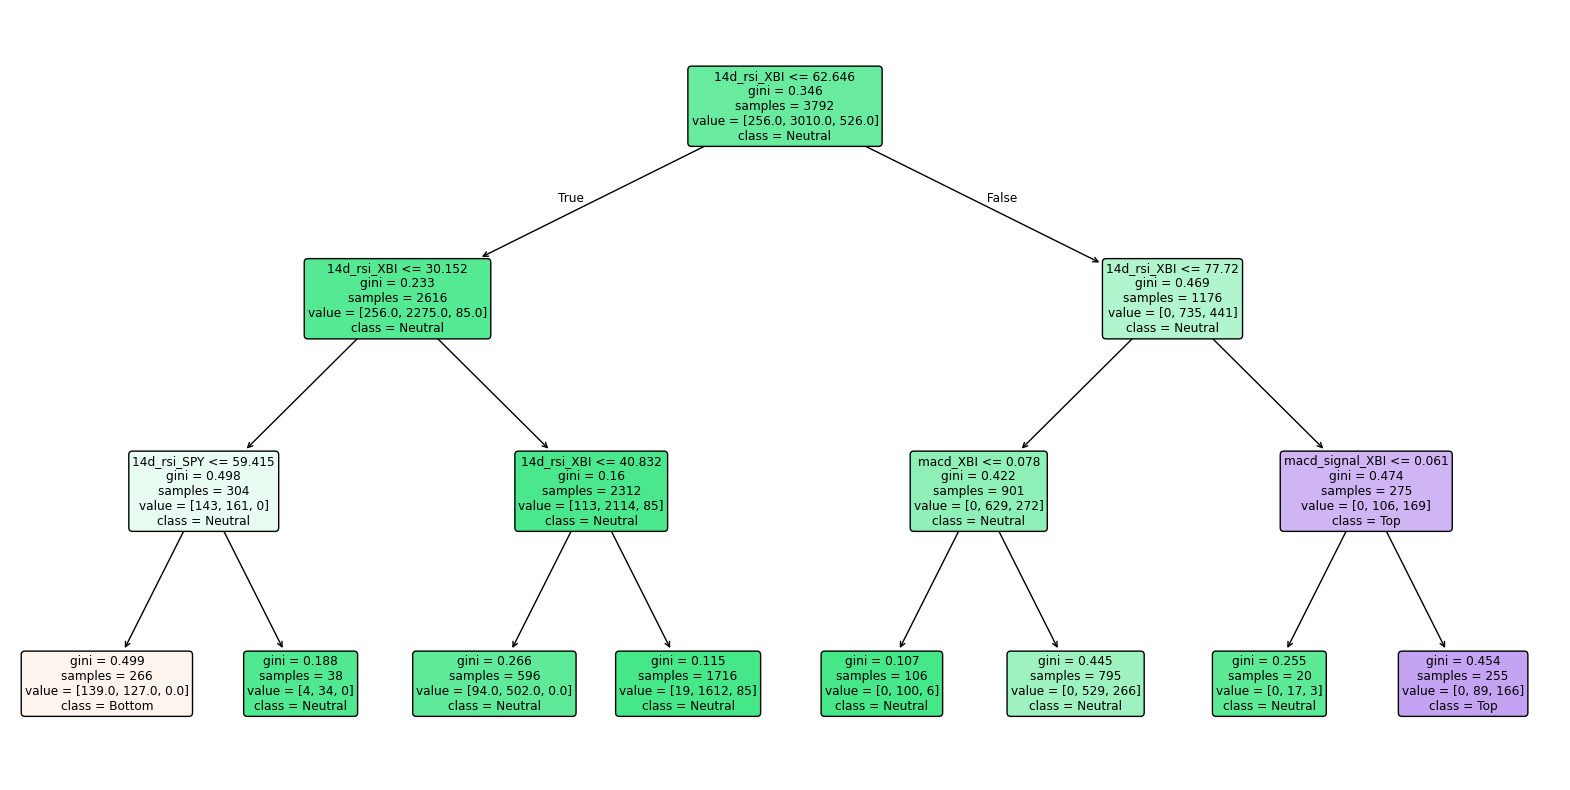

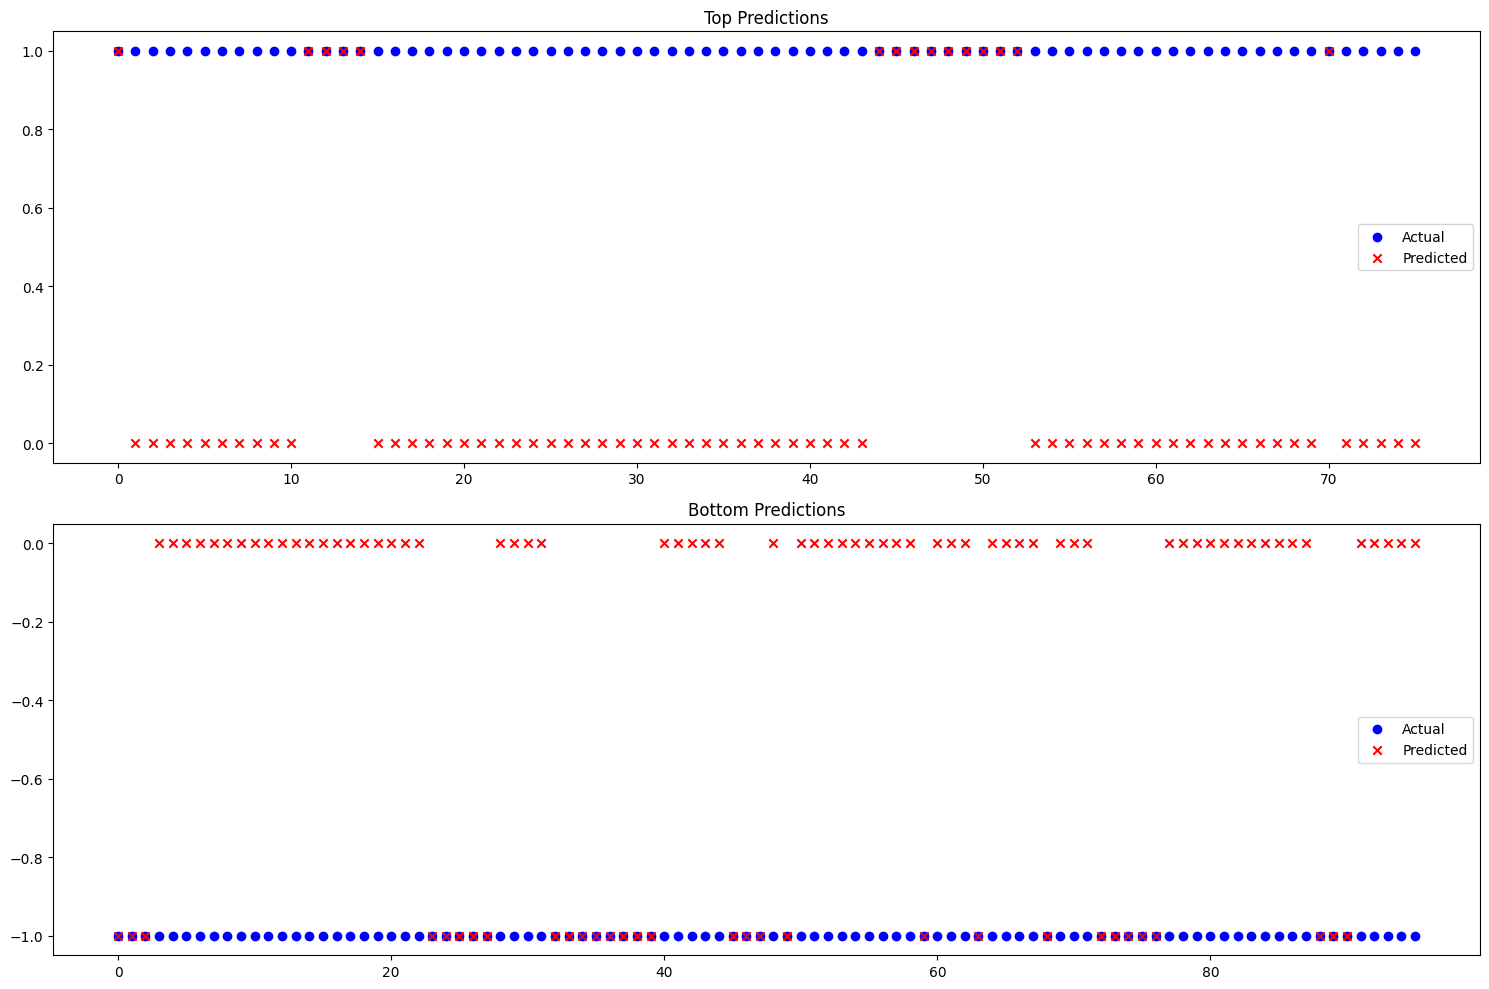

AssertionError: 

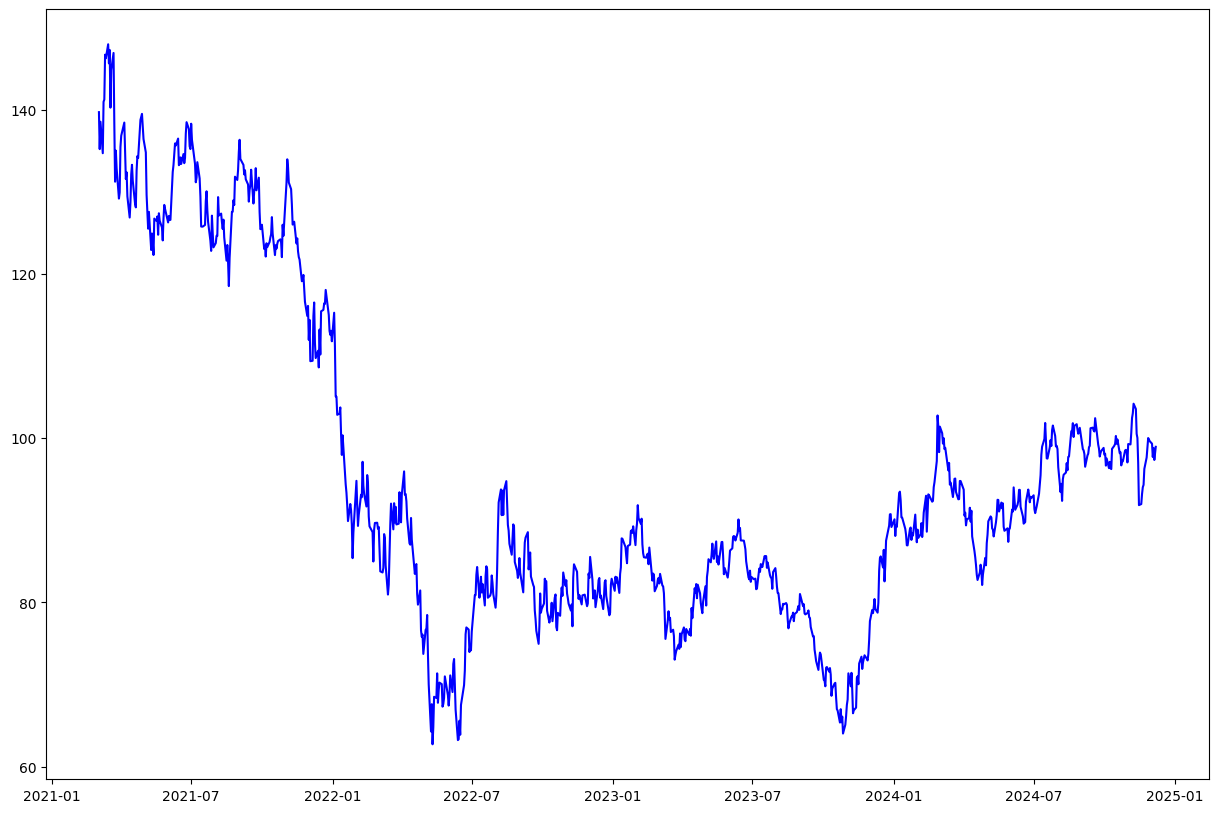

In [ ]:
# %% Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from yahooquery import Ticker
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from data_fetcher import fetch_ticker_data
import pickle,os
import warnings
warnings.filterwarnings("ignore")

# %% Helper functions for technical indicators
def compute_rsi(series, window=14):
    """Compute the Relative Strength Index (RSI) for a given series."""
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def compute_macd(series, short_window=12, long_window=26, signal_window=9):
    """Compute the MACD and signal line."""
    short_ema = series.ewm(span=short_window, min_periods=1).mean()
    long_ema = series.ewm(span=long_window, min_periods=1).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, min_periods=1).mean()
    return macd, signal

def compute_trending_down_percentage(df_ticker_data, period=5):
    """Compute the percentage of stocks in the dataset trending down over the specified period."""
    trending_down = sum(
        df_ticker_data.groupby('symbol').apply(
            lambda stock: stock['adjclose'].iloc[-1] / stock['adjclose'].iloc[-(period + 1)] - 1 < 0
        )
    )
    total_stocks = len(df_ticker_data['symbol'].unique())
    return (trending_down / total_stocks) * 100

def compute_market_breadth_indicators(df_ticker_data, tickers_mini):
    """Compute additional market breadth and sentiment indicators."""
    df_filtered = df_ticker_data[df_ticker_data['symbol'].isin(tickers_mini)]
    
    def is_above_200d_ma(stock_data):
        try:
            return stock_data['adjclose'].iloc[-1] > stock_data['adjclose'].rolling(window=200).mean().iloc[-1]
        except:
            return False
    
    above_200d_ma = df_filtered.groupby('symbol').apply(is_above_200d_ma).sum()
    pct_above_200d_ma = (above_200d_ma / len(tickers_mini)) * 100
    
    def compute_return_std(group):
        try:
            return group['adjclose'].pct_change().std()
        except:
            return 0
    
    market_return_std = df_filtered.groupby('symbol').apply(compute_return_std).mean()
    
    def is_52_week_high(stock_data):
        try:
            return stock_data['adjclose'].iloc[-1] == stock_data['adjclose'].rolling(window=252).max().iloc[-1]
        except:
            return False
    
    def is_52_week_low(stock_data):
        try:
            return stock_data['adjclose'].iloc[-1] == stock_data['adjclose'].rolling(window=252).min().iloc[-1]
        except:
            return False
    
    new_highs = df_filtered.groupby('symbol').apply(is_52_week_high).sum()
    new_lows = df_filtered.groupby('symbol').apply(is_52_week_low).sum()
    new_highs_ratio = (new_highs / len(tickers_mini)) * 100
    new_lows_ratio = (new_lows / len(tickers_mini)) * 100
    
    def compute_correlation(group):
        try:
            returns = group['adjclose'].pct_change()
            return returns
        except:
            return pd.Series()
    
    try:
        daily_returns = df_filtered.groupby('symbol').apply(compute_correlation)
        correlations = daily_returns.corr().mean().mean()
    except:
        correlations = 0
    
    def compute_momentum(stock_data, momentum_window=20):
        try:
            return stock_data['adjclose'].iloc[-1] / stock_data['adjclose'].iloc[-momentum_window] - 1
        except:
            return 0
    
    sector_momentum = df_filtered.groupby('symbol').apply(
        lambda stock: compute_momentum(stock)
    ).mean() * 100
    
    return {
        'pct_above_200d_ma': pct_above_200d_ma,
        'market_return_std': market_return_std,
        'new_highs_ratio': new_highs_ratio,
        'new_lows_ratio': new_lows_ratio,
        'avg_stock_correlation': correlations,
        'sector_momentum': sector_momentum
    }

# %% Data fetching and preprocessing
def load_tickers(file_path):
    """Load tickers from an Excel file."""
    tickers = pd.read_excel(file_path)
    return tickers[tickers.Country == "United States"].Ticker.unique().tolist()

def fetch_data(tickers, period='max', interval='1d'):
    """Fetch data for the tickers."""
    return fetch_ticker_data(tickers, period=period, interval=interval, filename=None)

def prepare_features_and_targets(df_ticker_data, tickers_mini, period=5):
    """Prepare features and targets for modeling."""
    # Filter data for XBI and SPY
    df_xbi = df_ticker_data[df_ticker_data['symbol'] == 'XBI'].copy()
    df_spy = df_ticker_data[df_ticker_data['symbol'] == 'SPY'].copy()
    
    # Calculate indicators for XBI
    df_xbi['7d_ma_XBI'] = df_xbi['adjclose'].rolling(window=7).mean()
    df_xbi['14d_rsi_XBI'] = compute_rsi(df_xbi['adjclose'])
    df_xbi['30d_ma_XBI'] = df_xbi['adjclose'].rolling(window=30).mean()
    df_xbi['macd_XBI'], df_xbi['macd_signal_XBI'] = compute_macd(df_xbi['adjclose'])
    df_xbi['volatility_XBI'] = df_xbi['adjclose'].rolling(window=14).std()
    
    # Compute market breadth indicators
    market_breadth = compute_market_breadth_indicators(df_ticker_data, tickers_mini)
    
    # Add market breadth indicators to the XBI dataframe
    df_xbi['pct_above_200d_ma'] = market_breadth['pct_above_200d_ma']
    df_xbi['market_return_std'] = market_breadth['market_return_std']
    df_xbi['new_highs_ratio'] = market_breadth['new_highs_ratio']
    df_xbi['new_lows_ratio'] = market_breadth['new_lows_ratio']
    df_xbi['avg_stock_correlation'] = market_breadth['avg_stock_correlation']
    df_xbi['sector_momentum'] = market_breadth['sector_momentum']
    
    # Define target for XBI: Local maxima = Top, Local minima = Bottom
    df_xbi['target_XBI'] = 0
    df_xbi.loc[df_xbi['adjclose'] == df_xbi['adjclose'].rolling(window=30).max(), 'target_XBI'] = 1
    df_xbi.loc[df_xbi['adjclose'] == df_xbi['adjclose'].rolling(window=30).min(), 'target_XBI'] = -1
    # OUTPUT THIS

    # Calculate indicators for SPY
    df_spy['7d_ma_SPY'] = df_spy['adjclose'].rolling(window=7).mean()
    df_spy['14d_rsi_SPY'] = compute_rsi(df_spy['adjclose'])
    df_spy['30d_ma_SPY'] = df_spy['adjclose'].rolling(window=30).mean()
    df_spy['macd_SPY'], df_spy['macd_signal_SPY'] = compute_macd(df_spy['adjclose'])
    df_spy['volatility_SPY'] = df_spy['adjclose'].rolling(window=14).std()
    
    # Merge SPY features into XBI
    df_combined = pd.merge(
        df_xbi, 
        df_spy[['date', 'adjclose', '7d_ma_SPY', '14d_rsi_SPY', '30d_ma_SPY', 'macd_SPY', 'macd_signal_SPY', 'volatility_SPY']], 
        on='date', 
        suffixes=('_XBI', '_SPY')
    )
    
    # Filter columns for features and target
    feature_columns = ['7d_ma_XBI', '14d_rsi_XBI', '30d_ma_XBI', 'macd_XBI', 'macd_signal_XBI', 
                       'volatility_XBI', 
                       '7d_ma_SPY', '14d_rsi_SPY', '30d_ma_SPY', 'macd_SPY', 'macd_signal_SPY', 'volatility_SPY']

    #feature_columns = ['new_highs_ratio', 'new_lows_ratio',  '30d_ma_SPY']
    X_combined = df_combined[feature_columns].fillna(0)  # Handle any missing values in features
    y_combined = df_combined['target_XBI']  # The target variable
    
    return X_combined, y_combined

# %% Model training and evaluation
def initialize_models():
    """Initialize and return a dictionary of models."""
    return {
        'DecisionTree': DecisionTreeClassifier(
            max_depth=3,  # Limit the depth of the tree
            min_samples_split=10,  # Minimum samples required to split an internal node
            min_samples_leaf=5,  # Minimum samples required to be at a leaf node
            random_state=42
        )  
    }

def train_and_evaluate_model(X_combined, y_combined):
    """Train and evaluate the decision tree model."""
    X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42,shuffle=False)
     
    models = initialize_models()
    model = models['DecisionTree']
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    
    # Plot the decision tree
    plt.figure(figsize=(20,10))
    plot_tree(model, 
              feature_names=X_combined.columns, 
              class_names=['Bottom', 'Neutral', 'Top'], 
              filled=True, 
              rounded=True, 
              impurity=True)
    plt.show()

def plot_predictions_vs_actual(X_combined, y_combined, model):
    """
    Plot actual XBI prices and model predictions
    
    Parameters:
    - X_combined: Feature matrix
    - y_combined: Actual target values
    - model: Trained decision tree classifier
    """
    # Split data without shuffling to maintain time sequence
    X_train, X_test, y_train, y_test = train_test_split(
        X_combined, y_combined, 
        test_size=0.2, 
        random_state=42, 
        shuffle=False
    )
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Create a figure with subplots
    plt.figure(figsize=(15, 10))
    
    # Plot for Top predictions
    plt.subplot(2, 1, 1)
    top_indices = y_test == 1
    plt.scatter(
        range(sum(top_indices)), 
        y_test[top_indices], 
        label='Actual', 
        color='blue'
    )
    plt.scatter(
        range(sum(top_indices)), 
        y_pred[top_indices], 
        label='Predicted', 
        color='red', 
        marker='x'
    )
    plt.title('Top Predictions')
    plt.legend()
    
    # Plot for Bottom predictions
    plt.subplot(2, 1, 2)
    bottom_indices = y_test == -1
    plt.scatter(
        range(sum(bottom_indices)), 
        y_test[bottom_indices], 
        label='Actual', 
        color='blue'
    )
    plt.scatter(
        range(sum(bottom_indices)), 
        y_pred[bottom_indices], 
        label='Predicted', 
        color='red', 
        marker='x'
    )
    plt.title('Bottom Predictions')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_predictions_with_price(X_combined, y_combined, df_ticker_data, model):
    # Split data without shuffling to maintain time sequence
    X_train, X_test, y_train, y_test = train_test_split(
        X_combined, y_combined, test_size=0.2, random_state=42, shuffle=False
    )
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Get XBI price data
    df_xbi = df_ticker_data[df_ticker_data['symbol'] == 'XBI'].copy()
    
    # Reset index to ensure alignment
    df_xbi = df_xbi.reset_index(drop=True)
    
    # Create a slice of df_xbi corresponding to the test set
    df_xbi_test = df_xbi.iloc[-len(y_test):]
    
    # Create figure with subplots
    plt.figure(figsize=(15, 10))
    
    # Plot actual XBI prices
    plt.plot(df_xbi_test['date'], df_xbi_test['adjclose'], label='XBI Price', color='blue')
    
    # Highlight prediction points
    top_indices = y_test == 1
    bottom_indices = y_test == -1
    
    plt.scatter(
        df_xbi_test.loc[top_indices, 'date'], 
        df_xbi_test.loc[top_indices, 'adjclose'], 
        color='green', 
        marker='^', 
        label='Predicted Top'
    )
    
    plt.scatter(
        df_xbi_test.loc[bottom_indices, 'date'], 
        df_xbi_test.loc[bottom_indices, 'adjclose'], 
        color='red', 
        marker='v', 
        label='Predicted Bottom'
    )
    
    plt.title('XBI Price with Market Condition Predictions')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# %% Main script execution
if __name__ == "__main__":
    # Load tickers and fetch data
    tickers = load_tickers("Input/Complete-List-of-Biotech-Stocks-Listed-on-NASDAQ-Jan-1-24.xlsx")
    tickers_mini = tickers  # Sample for testing
    benchmark_tickers = ["XBI", "SPY"]
    tickers_full = tickers_mini + benchmark_tickers
    
    # Fetch data
    df_ticker_daily = fetch_data(tickers_full)

    
    # Prepare features and targets for model
    X_combined, y_combined = prepare_features_and_targets(df_ticker_daily, tickers_full, period=5)
    
    # Train and evaluate the model
    train_and_evaluate_model(X_combined, y_combined)

    models = initialize_models()
    model = models['DecisionTree']
    model.fit(X_combined, y_combined)  # Train on most data
    
    # Plot predictions vs actual
    plot_predictions_vs_actual(X_combined, y_combined, model)

    # Call the function in main script
    plot_predictions_with_price(X_combined, y_combined, df_ticker_daily, model)


### FINALE

Classification Report:
               precision    recall  f1-score   support

          -1       0.49      0.47      0.48        96
           0       0.86      0.93      0.90       777
           1       0.76      0.17      0.28        76

    accuracy                           0.83       949
   macro avg       0.71      0.52      0.55       949
weighted avg       0.82      0.83      0.81       949

Confusion Matrix:
 [[ 45  51   0]
 [ 47 726   4]
 [  0  63  13]]
Test Accuracy: 0.8261327713382508


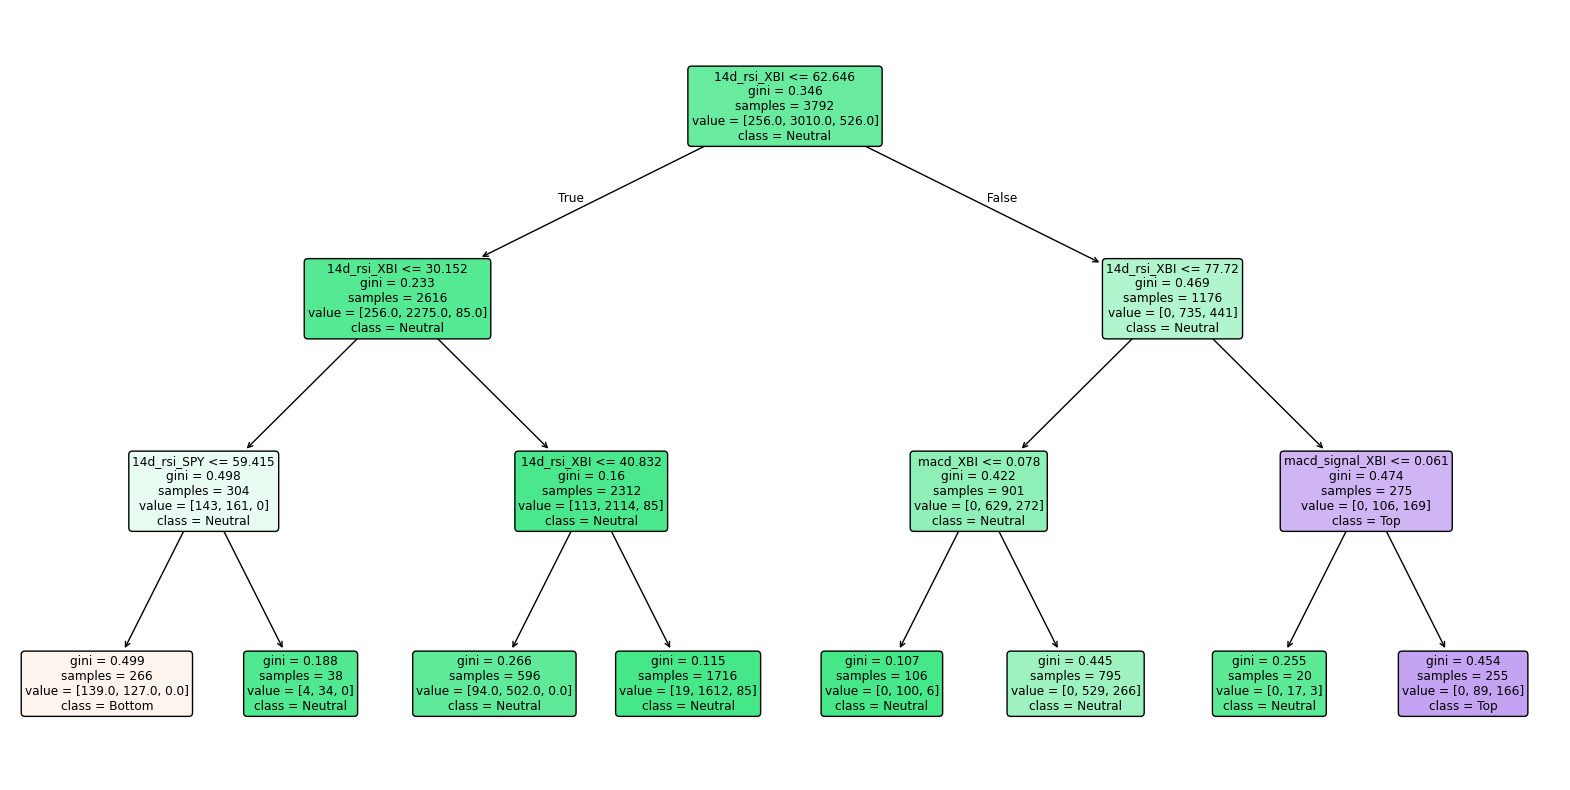

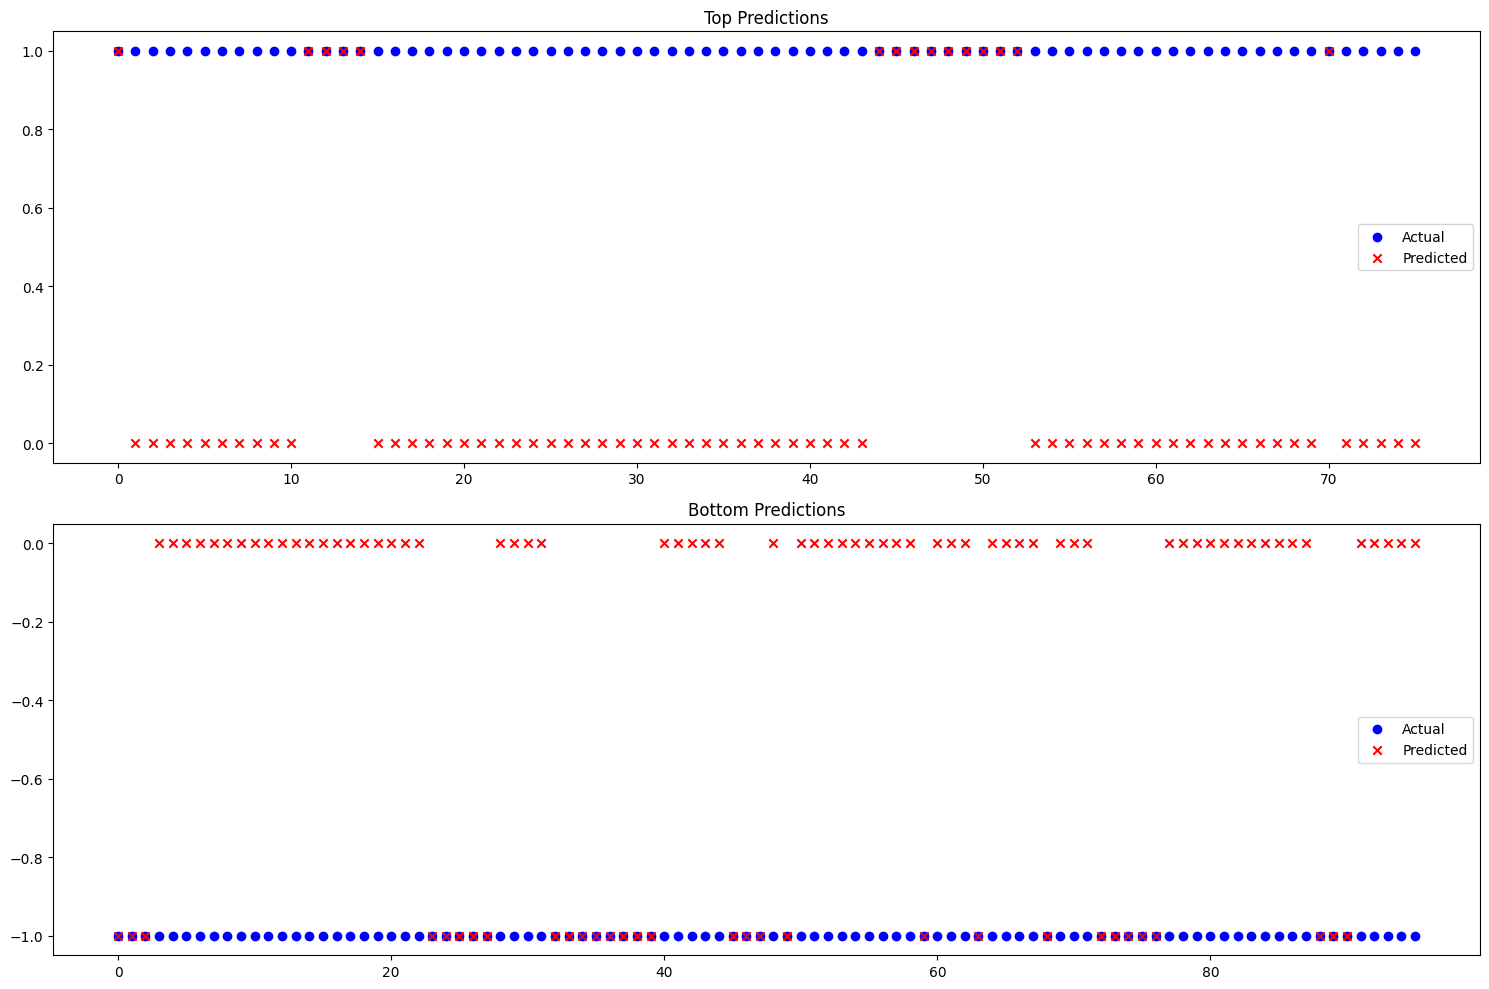

AssertionError: 

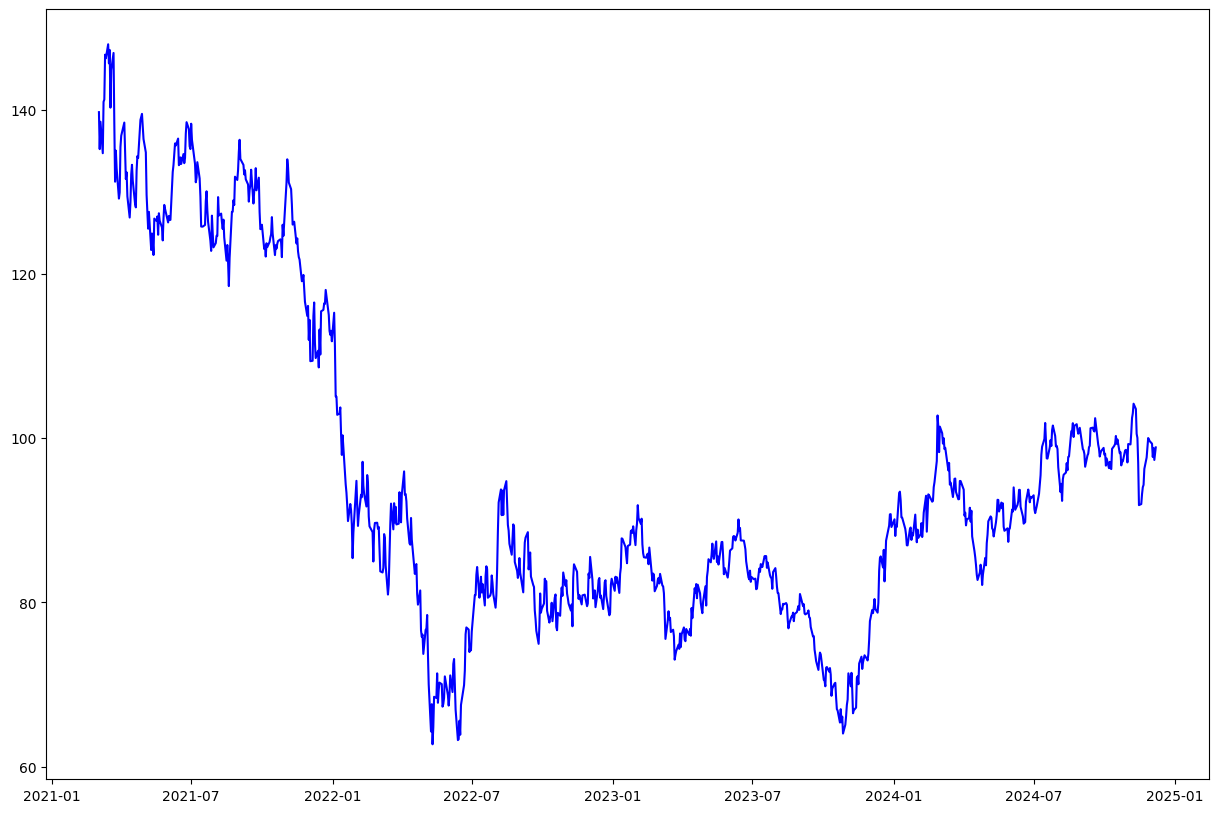

In [ ]:
# %% Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from yahooquery import Ticker
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from data_fetcher import fetch_ticker_data
import pickle,os
import warnings
warnings.filterwarnings("ignore")

# %% Helper functions for technical indicators
def compute_rsi(series, window=14):
    """Compute the Relative Strength Index (RSI) for a given series."""
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def compute_macd(series, short_window=12, long_window=26, signal_window=9):
    """Compute the MACD and signal line."""
    short_ema = series.ewm(span=short_window, min_periods=1).mean()
    long_ema = series.ewm(span=long_window, min_periods=1).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, min_periods=1).mean()
    return macd, signal

def compute_trending_down_percentage(df_ticker_data, period=5):
    """Compute the percentage of stocks in the dataset trending down over the specified period."""
    trending_down = sum(
        df_ticker_data.groupby('symbol').apply(
            lambda stock: stock['adjclose'].iloc[-1] / stock['adjclose'].iloc[-(period + 1)] - 1 < 0
        )
    )
    total_stocks = len(df_ticker_data['symbol'].unique())
    return (trending_down / total_stocks) * 100

def compute_market_breadth_indicators(df_ticker_data, tickers_mini):
    """Compute additional market breadth and sentiment indicators."""
    df_filtered = df_ticker_data[df_ticker_data['symbol'].isin(tickers_mini)]
    
    def is_above_200d_ma(stock_data):
        try:
            return stock_data['adjclose'].iloc[-1] > stock_data['adjclose'].rolling(window=200).mean().iloc[-1]
        except:
            return False
    
    above_200d_ma = df_filtered.groupby('symbol').apply(is_above_200d_ma).sum()
    pct_above_200d_ma = (above_200d_ma / len(tickers_mini)) * 100
    
    def compute_return_std(group):
        try:
            return group['adjclose'].pct_change().std()
        except:
            return 0
    
    market_return_std = df_filtered.groupby('symbol').apply(compute_return_std).mean()
    
    def is_52_week_high(stock_data):
        try:
            return stock_data['adjclose'].iloc[-1] == stock_data['adjclose'].rolling(window=252).max().iloc[-1]
        except:
            return False
    
    def is_52_week_low(stock_data):
        try:
            return stock_data['adjclose'].iloc[-1] == stock_data['adjclose'].rolling(window=252).min().iloc[-1]
        except:
            return False
    
    new_highs = df_filtered.groupby('symbol').apply(is_52_week_high).sum()
    new_lows = df_filtered.groupby('symbol').apply(is_52_week_low).sum()
    new_highs_ratio = (new_highs / len(tickers_mini)) * 100
    new_lows_ratio = (new_lows / len(tickers_mini)) * 100
    
    def compute_correlation(group):
        try:
            returns = group['adjclose'].pct_change()
            return returns
        except:
            return pd.Series()
    
    try:
        daily_returns = df_filtered.groupby('symbol').apply(compute_correlation)
        correlations = daily_returns.corr().mean().mean()
    except:
        correlations = 0
    
    def compute_momentum(stock_data, momentum_window=20):
        try:
            return stock_data['adjclose'].iloc[-1] / stock_data['adjclose'].iloc[-momentum_window] - 1
        except:
            return 0
    
    sector_momentum = df_filtered.groupby('symbol').apply(
        lambda stock: compute_momentum(stock)
    ).mean() * 100
    
    return {
        'pct_above_200d_ma': pct_above_200d_ma,
        'market_return_std': market_return_std,
        'new_highs_ratio': new_highs_ratio,
        'new_lows_ratio': new_lows_ratio,
        'avg_stock_correlation': correlations,
        'sector_momentum': sector_momentum
    }

# %% Data fetching and preprocessing
def load_tickers(file_path):
    """Load tickers from an Excel file."""
    tickers = pd.read_excel(file_path)
    return tickers[tickers.Country == "United States"].Ticker.unique().tolist()

def fetch_data(tickers, period='max', interval='1d'):
    """Fetch data for the tickers."""
    return fetch_ticker_data(tickers, period=period, interval=interval, filename=None)

def prepare_features_and_targets(df_ticker_data, tickers_mini, period=5):
    """Prepare features and targets for modeling."""
    # Filter data for XBI and SPY
    df_xbi = df_ticker_data[df_ticker_data['symbol'] == 'XBI'].copy()
    df_spy = df_ticker_data[df_ticker_data['symbol'] == 'SPY'].copy()
    
    # Calculate indicators for XBI
    df_xbi['7d_ma_XBI'] = df_xbi['adjclose'].rolling(window=7).mean()
    df_xbi['14d_rsi_XBI'] = compute_rsi(df_xbi['adjclose'])
    df_xbi['30d_ma_XBI'] = df_xbi['adjclose'].rolling(window=30).mean()
    df_xbi['macd_XBI'], df_xbi['macd_signal_XBI'] = compute_macd(df_xbi['adjclose'])
    df_xbi['volatility_XBI'] = df_xbi['adjclose'].rolling(window=14).std()
    
    # Compute market breadth indicators
    market_breadth = compute_market_breadth_indicators(df_ticker_data, tickers_mini)
    
    # Add market breadth indicators to the XBI dataframe
    df_xbi['pct_above_200d_ma'] = market_breadth['pct_above_200d_ma']
    df_xbi['market_return_std'] = market_breadth['market_return_std']
    df_xbi['new_highs_ratio'] = market_breadth['new_highs_ratio']
    df_xbi['new_lows_ratio'] = market_breadth['new_lows_ratio']
    df_xbi['avg_stock_correlation'] = market_breadth['avg_stock_correlation']
    df_xbi['sector_momentum'] = market_breadth['sector_momentum']
    
    # Define target for XBI: Local maxima = Top, Local minima = Bottom
    df_xbi['target_XBI'] = 0
    df_xbi.loc[df_xbi['adjclose'] == df_xbi['adjclose'].rolling(window=30).max(), 'target_XBI'] = 1
    df_xbi.loc[df_xbi['adjclose'] == df_xbi['adjclose'].rolling(window=30).min(), 'target_XBI'] = -1
    # OUTPUT THIS

    # Calculate indicators for SPY
    df_spy['7d_ma_SPY'] = df_spy['adjclose'].rolling(window=7).mean()
    df_spy['14d_rsi_SPY'] = compute_rsi(df_spy['adjclose'])
    df_spy['30d_ma_SPY'] = df_spy['adjclose'].rolling(window=30).mean()
    df_spy['macd_SPY'], df_spy['macd_signal_SPY'] = compute_macd(df_spy['adjclose'])
    df_spy['volatility_SPY'] = df_spy['adjclose'].rolling(window=14).std()
    
    # Merge SPY features into XBI
    df_combined = pd.merge(
        df_xbi, 
        df_spy[['date', 'adjclose', '7d_ma_SPY', '14d_rsi_SPY', '30d_ma_SPY', 'macd_SPY', 'macd_signal_SPY', 'volatility_SPY']], 
        on='date', 
        suffixes=('_XBI', '_SPY')
    )
    
    # Filter columns for features and target
    feature_columns = ['7d_ma_XBI', '14d_rsi_XBI', '30d_ma_XBI', 'macd_XBI', 'macd_signal_XBI', 
                       'volatility_XBI', 
                       '7d_ma_SPY', '14d_rsi_SPY', '30d_ma_SPY', 'macd_SPY', 'macd_signal_SPY', 'volatility_SPY']

    #feature_columns = ['new_highs_ratio', 'new_lows_ratio',  '30d_ma_SPY']
    X_combined = df_combined[feature_columns].fillna(0)  # Handle any missing values in features
    y_combined = df_combined['target_XBI']  # The target variable
    
    return X_combined, y_combined

# %% Model training and evaluation
def initialize_models():
    """Initialize and return a dictionary of models."""
    return {
        'DecisionTree': DecisionTreeClassifier(
            max_depth=3,  # Limit the depth of the tree
            min_samples_split=10,  # Minimum samples required to split an internal node
            min_samples_leaf=5,  # Minimum samples required to be at a leaf node
            random_state=42
        )  
    }

def train_and_evaluate_model(X_combined, y_combined):
    """Train and evaluate the decision tree model."""
    X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42,shuffle=False)
     
    models = initialize_models()
    model = models['DecisionTree']
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    
    # Plot the decision tree
    plt.figure(figsize=(20,10))
    plot_tree(model, 
              feature_names=X_combined.columns, 
              class_names=['Bottom', 'Neutral', 'Top'], 
              filled=True, 
              rounded=True, 
              impurity=True)
    plt.show()

def plot_predictions_vs_actual(X_combined, y_combined, model):
    """
    Plot actual XBI prices and model predictions
    
    Parameters:
    - X_combined: Feature matrix
    - y_combined: Actual target values
    - model: Trained decision tree classifier
    """
    # Split data without shuffling to maintain time sequence
    X_train, X_test, y_train, y_test = train_test_split(
        X_combined, y_combined, 
        test_size=0.2, 
        random_state=42, 
        shuffle=False
    )
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Create a figure with subplots
    plt.figure(figsize=(15, 10))
    
    # Plot for Top predictions
    plt.subplot(2, 1, 1)
    top_indices = y_test == 1
    plt.scatter(
        range(sum(top_indices)), 
        y_test[top_indices], 
        label='Actual', 
        color='blue'
    )
    plt.scatter(
        range(sum(top_indices)), 
        y_pred[top_indices], 
        label='Predicted', 
        color='red', 
        marker='x'
    )
    plt.title('Top Predictions')
    plt.legend()
    
    # Plot for Bottom predictions
    plt.subplot(2, 1, 2)
    bottom_indices = y_test == -1
    plt.scatter(
        range(sum(bottom_indices)), 
        y_test[bottom_indices], 
        label='Actual', 
        color='blue'
    )
    plt.scatter(
        range(sum(bottom_indices)), 
        y_pred[bottom_indices], 
        label='Predicted', 
        color='red', 
        marker='x'
    )
    plt.title('Bottom Predictions')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_predictions_with_price(X_combined, y_combined, df_ticker_data, model):
    # Split data without shuffling to maintain time sequence
    X_train, X_test, y_train, y_test = train_test_split(
        X_combined, y_combined, test_size=0.2, random_state=42, shuffle=False
    )
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Get XBI price data
    df_xbi = df_ticker_data[df_ticker_data['symbol'] == 'XBI'].copy()
    
    # Reset index to ensure alignment
    df_xbi = df_xbi.reset_index(drop=True)
    
    # Create a slice of df_xbi corresponding to the test set
    df_xbi_test = df_xbi.iloc[-len(y_test):]
    
    # Create figure with subplots
    plt.figure(figsize=(15, 10))
    
    # Plot actual XBI prices
    plt.plot(df_xbi_test['date'], df_xbi_test['adjclose'], label='XBI Price', color='blue')
    
    # Highlight prediction points
    top_indices = y_test == 1
    bottom_indices = y_test == -1
    
    plt.scatter(
        df_xbi_test.loc[top_indices, 'date'], 
        df_xbi_test.loc[top_indices, 'adjclose'], 
        color='green', 
        marker='^', 
        label='Predicted Top'
    )
    
    plt.scatter(
        df_xbi_test.loc[bottom_indices, 'date'], 
        df_xbi_test.loc[bottom_indices, 'adjclose'], 
        color='red', 
        marker='v', 
        label='Predicted Bottom'
    )
    
    plt.title('XBI Price with Market Condition Predictions')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# %% Main script execution
if __name__ == "__main__":
    # Load tickers and fetch data
    tickers = load_tickers("Input/Complete-List-of-Biotech-Stocks-Listed-on-NASDAQ-Jan-1-24.xlsx")
    tickers_mini = tickers  # Sample for testing
    benchmark_tickers = ["XBI", "SPY"]
    tickers_full = tickers_mini + benchmark_tickers
    
    # Fetch data
    df_ticker_daily = fetch_data(tickers_full)

    
    # Prepare features and targets for model
    X_combined, y_combined = prepare_features_and_targets(df_ticker_daily, tickers_full, period=5)
    
    # Train and evaluate the model
    train_and_evaluate_model(X_combined, y_combined)

    models = initialize_models()
    model = models['DecisionTree']
    model.fit(X_combined, y_combined)  # Train on most data
    
    # Plot predictions vs actual
    plot_predictions_vs_actual(X_combined, y_combined, model)

    # Call the function in main script
    plot_predictions_with_price(X_combined, y_combined, df_ticker_daily, model)


In [ ]:
# Fetch the live XBI data from Yahoo Finance
def fetch_live_data(ticker='XBI'):
    """Fetch the latest data for the given ticker from Yahoo Finance."""
    xbi = Ticker(ticker)
    xbi_history = xbi.history(period='1d', interval='1m')  # Fetch daily data
    return xbi_history

# Need to let the code fire off top/bottom signals ; use the criteria rather than train/test split

## Root Node  
The decision tree starts with the condition 14d_rsi_XBI <= 62.646, containing 3,792 samples and a Gini impurity of 0.346. The value distribution is [256.0, 3010.0, 526.0], with a classification of Neutral.  

## Main Branches  
The tree splits into two main paths:  

**Left Branch** (14d_rsi_XBI <= 30.152):  
- Contains 2,616 samples with a Gini impurity of 0.233.  
- Value distribution: [256.0, 2275.0, 85.0].  
- Further splits based on 14d_rsi_SPY and 14d_rsi_XBI.  
- Predominantly predicts Neutral outcomes.  

**Right Branch** (14d_rsi_XBI > 62.646):  
- Contains 1,176 samples with a higher Gini impurity of 0.469.  
- Value distribution: [0, 735, 441].  
- Splits based on macd_XBI and macd_signal_XBI.  
- Predictions are more varied, including Top classifications.  

## Terminal Predictions  

**Bottom Predictions:**  
- Found in the leftmost leaf with 266 samples.  
- Value distribution: [139.0, 127.0, 0.0].  
- Triggered when 14d_rsi_SPY <= 59.415.  
- High confidence with a Gini impurity of 0.499.  

**Top Predictions:**  
- Found in the rightmost branches.  
- The most confident Top prediction has 275 samples.  
- Triggered when macd_signal_XBI <= 0.061.  
- Value distribution: [0, 106, 169].  

**Neutral Predictions:**  
- Predominate in the middle branches.  
- The largest Neutral node has 1,716 samples.  
- Occurs with moderate XBI RSI values.  
- Shows consistent Gini impurity between 0.11 and 0.16.  

The tree shows that technical indicators like RSI and MACD effectively classify market conditions, with more reliable predictions at extreme values and more uncertainty in the middle ranges.  
